In [2]:
import os
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

# --- Helper: Read a CSV in chunks and sample rows without loading the entire file into memory.
def read_and_sample_csv(file_path, max_rows=4000, chunksize=100000):
    sampled_chunks = []
    total_sampled = 0
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        # Determine the fraction to sample from this chunk.
        sample_frac = min(1.0, (max_rows - total_sampled) / len(chunk))
        sampled_chunk = chunk.sample(frac=sample_frac, random_state=42)
        sampled_chunks.append(sampled_chunk)
        total_sampled += len(sampled_chunk)
        if total_sampled >= max_rows:
            break
    combined = pd.concat(sampled_chunks)
    # Only sample down to max_rows if there are more rows than desired.
    if len(combined) > max_rows:
        combined = combined.sample(n=max_rows, random_state=42)
    return combined

# --- Main visualization pipeline function ---
def run_visualization_pipeline(
    datasets, 
    mode='auto', 
    output_csv=None, 
    save_plots=False,  # not used in this version; behavior is controlled by mode
    max_rows=4000,             # Downsample if dataset exceeds this many rows
    max_numeric_pairs=5,       # Maximum numeric-numeric pairs to visualize
    max_cat_pairs=5            # Maximum numeric-categorical or categorical-categorical pairs to visualize
):
    """
    Run a visualization pipeline in two modes:
    
    1. Normal Mode: Given one or more CSV files, only the enhanced (AI-recommended) graphs
       are output (displayed inline) along with summary metrics.
       
    2. Compare Mode: Given one or more CSV files, both baseline and enhanced graphs are generated.
       Instead of displaying graphs, they are saved to a directory ("compare_output"). The results 
       (comparison metrics between baseline and enhanced) are printed and returned as a DataFrame.
    
    Parameters:
    - datasets: A pandas DataFrame, a file path to a CSV, or a list of such datasets.
    - mode: 'normal' (default if one dataset) displays enhanced graphs;
             'compare' saves graphs to disk and compares baseline vs enhanced;
             'auto' infers mode from the number of datasets.
    - output_csv: (Optional) Path to save the comparison results CSV (used in compare mode).
    - max_rows: (int) Downsample large datasets to this many rows.
    - max_numeric_pairs: (int) Maximum numeric-numeric pairs to visualize.
    - max_cat_pairs: (int) Maximum numeric-categorical or categorical-categorical pairs to visualize.
    
    Returns:
    - In normal mode: A dictionary of summary metrics for the (first) dataset.
    - In compare mode: A pandas DataFrame of summary metrics for each dataset.
    """
    import sys
    from joblib import Parallel, delayed

    # Optional: use textstat for readability if available.
    try:
        import textstat
    except ImportError:
        textstat = None

    # --- Helper: Compute mutual information with discretization ---
    def compute_mutual_info(series1, series2, bins=10):
        df_pair = pd.DataFrame({'X': series1, 'Y': series2}).dropna()
        if df_pair.empty:
            return 0.0
        X = df_pair['X']
        Y = df_pair['Y']

        def discretize(series, bins):
            if pd.api.types.is_numeric_dtype(series):
                unique_vals = series.nunique(dropna=True)
                if unique_vals > bins:
                    try:
                        binned = pd.qcut(series, q=bins, duplicates='drop')
                    except Exception:
                        binned = pd.cut(series, bins=bins)
                    codes = pd.Categorical(binned).codes
                else:
                    codes = pd.Categorical(series).codes
            else:
                codes = pd.Categorical(series).codes
            return codes

        X_disc = discretize(X, bins)
        Y_disc = discretize(Y, bins)
        valid_mask = (X_disc >= 0) & (Y_disc >= 0)
        X_disc, Y_disc = X_disc[valid_mask], Y_disc[valid_mask]
        if X_disc.size == 0 or Y_disc.size == 0 or (np.unique(X_disc).size < 2 or np.unique(Y_disc).size < 2):
            return 0.0
        return mutual_info_score(X_disc, Y_disc)

    # --- Cache for mutual information computations ---
    mi_cache = {}
    def get_mutual_info(col1, col2):
        key = tuple(sorted([col1, col2]))
        if key not in mi_cache:
            mi_cache[key] = compute_mutual_info(data[col1], data[col2])
        return mi_cache[key]

    # Determine mode: if auto then if more than one dataset use compare, else normal.
    dataset_list = datasets if isinstance(datasets, list) else [datasets]
    if mode == 'auto':
        mode = 'compare' if len(dataset_list) > 1 else 'normal'

    results = []

    for idx, data_input in enumerate(dataset_list):
        mi_cache.clear()  # reset cache per dataset

        # Determine dataset name.
        if isinstance(data_input, str):
            dataset_name = os.path.basename(data_input).split('.')[0]
        else:
            dataset_name = f"Dataset{idx+1}"

        # --- Data Loading with memory optimization ---
        if isinstance(data_input, pd.DataFrame):
            data = data_input.copy()
        elif isinstance(data_input, str):
            # Check file size to decide whether to use Dask or fallback to chunked reading.
            file_size = os.stat(data_input).st_size
            try:
                import dask.dataframe as dd
                # If file is large (> 50 MB), use Dask to sample before computing.
                if file_size > 50 * 1024 * 1024:
                    ddf = dd.read_csv(data_input)
                    estimated_rows = ddf.shape[0].compute()
                    fraction = max_rows / estimated_rows if estimated_rows > max_rows else 1.0
                    data = ddf.sample(frac=fraction, random_state=42).compute()
                else:
                    data = dd.read_csv(data_input, assume_missing = True).compute()
            except ImportError:
                # Fall back on chunked reading using pandas.
                data = read_and_sample_csv(data_input, max_rows=max_rows, chunksize=100000)
        else:
            try:
                data = pd.DataFrame(data_input)
            except Exception as e:
                print(f"Unrecognized data format for input {idx+1}: {e}", file=sys.stderr)
                continue

        if len(data) > max_rows:
            data = data.sample(n=max_rows, random_state=42)
            print(f"[INFO] {dataset_name}: Downsampled to {max_rows} rows.")

        # --- Separate columns by type ---
        numeric_cols, cat_cols = [], []
        for col in data.columns:
            if (pd.api.types.is_bool_dtype(data[col]) or 
                isinstance(data[col].dtype, pd.CategoricalDtype) or 
                data[col].dtype == object):
                cat_cols.append(col)
            elif pd.api.types.is_numeric_dtype(data[col]):
                # Treat integer columns with few unique values as categorical.
                if pd.api.types.is_integer_dtype(data[col]) and data[col].nunique(dropna=True) <= 15:
                    cat_cols.append(col)
                else:
                    numeric_cols.append(col)
            else:
                cat_cols.append(col)
        numeric_cols = [c for c in numeric_cols if c not in cat_cols]

        ############################################################################
        # Generate Visualizations (Baseline and AI/Enhanced)
        ############################################################################
        baseline_charts = []
        ai_charts = []

        # --- Numeric-Numeric comparisons ---
        numeric_pairs = list(itertools.combinations(numeric_cols, 2))
        # Baseline: compute Pearson correlations (in parallel).
        def compute_corr_for_pair(col1, col2):
            subdf = data[[col1, col2]].dropna()
            if subdf.empty:
                return None
            try:
                r_val, p_val = stats.pearsonr(subdf[col1], subdf[col2])
            except Exception:
                r_val, p_val = np.nan, np.nan
            return (abs(r_val), col1, col2, r_val, p_val)
        corr_list = Parallel(n_jobs=-1)(
            delayed(compute_corr_for_pair)(col1, col2) for col1, col2 in numeric_pairs
        )
        corr_list = [res for res in corr_list if res is not None]
        corr_list.sort(key=lambda x: x[0], reverse=True)
        for abs_r, col1, col2, r_val, p_val in corr_list[:max_numeric_pairs]:
            baseline_charts.append({
                "type": "scatter",
                "x": col1, "y": col2,
                "p_value": float(p_val) if (p_val == p_val) else None,
                "mutual_info": None,
                "description": f"Scatter plot of {col1} vs {col2} (Baseline)."
            })

        # AI/Enhanced: compute mutual information (parallel with caching).
        def compute_mi_for_pair(col1, col2):
            subdf = data[[col1, col2]].dropna()
            if subdf.empty:
                return None
            mi_val = get_mutual_info(col1, col2)
            try:
                r_val, p_val = stats.pearsonr(subdf[col1], subdf[col2])
            except Exception:
                r_val, p_val = np.nan, np.nan
            return (mi_val, col1, col2, r_val, p_val)
        mi_list = Parallel(n_jobs=-1)(
            delayed(compute_mi_for_pair)(col1, col2) for col1, col2 in numeric_pairs
        )
        mi_list = [res for res in mi_list if res is not None]
        mi_list.sort(key=lambda x: x[0], reverse=True)
        for mi_val, col1, col2, r_val, p_val in mi_list[:max_numeric_pairs]:
            if p_val == p_val and p_val < 0.05:
                strength = "strong" if abs(r_val) > 0.7 else ("moderate" if abs(r_val) > 0.3 else "weak")
                direction = "positive" if r_val >= 0 else "negative"
                desc = f"Scatter plot of {col1} vs {col2}: {strength} {direction} correlation (p={p_val:.3f})."
            else:
                desc = f"Scatter plot of {col1} vs {col2} (mutual info={mi_val:.2f})."
            ai_charts.append({
                "type": "scatter",
                "x": col1, "y": col2,
                "p_value": float(p_val) if (p_val == p_val) else None,
                "mutual_info": float(mi_val),
                "description": desc
            })

        # --- Numeric-Categorical comparisons ---
        num_cat_candidates = []
        for num in numeric_cols:
            for cat in cat_cols:
                subdf = data[[num, cat]].dropna()
                if subdf.empty or subdf[cat].nunique() < 2:
                    continue
                groups = [subdf[subdf[cat] == val][num].values for val in subdf[cat].unique()]
                if len(groups) < 2 or any(len(g) < 2 for g in groups):
                    continue
                if len(groups) == 2:
                    _, p_val = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                else:
                    _, p_val = stats.f_oneway(*groups)
                if p_val == p_val:
                    num_cat_candidates.append((p_val, num, cat))
        num_cat_candidates.sort(key=lambda x: x[0])
        for p_val, num, cat in num_cat_candidates[:max_cat_pairs]:
            baseline_charts.append({
                "type": "boxplot",
                "x": cat, "y": num,
                "p_value": float(p_val),
                "mutual_info": None,
                "description": f"Boxplot of {num} by {cat} (Baseline)."
            })
        # Enhanced version for numeric-categorical.
        mi_num_cat = []
        for num in numeric_cols:
            for cat in cat_cols:
                subdf = data[[num, cat]].dropna()
                if subdf.empty or subdf[cat].nunique() < 2:
                    continue
                mi_val = get_mutual_info(num, cat)
                groups = [subdf[subdf[cat] == val][num].values for val in subdf[cat].unique()]
                if len(groups) < 2 or any(len(g) < 2 for g in groups):
                    continue
                if len(groups) == 2:
                    _, p_val = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                else:
                    _, p_val = stats.f_oneway(*groups)
                mi_num_cat.append((mi_val, num, cat, p_val))
        mi_num_cat.sort(key=lambda x: x[0], reverse=True)
        for mi_val, num, cat, p_val in mi_num_cat[:max_cat_pairs]:
            if p_val == p_val and p_val < 0.05:
                desc = f"Boxplot of {num} by {cat}: significant difference (p={p_val:.3f})."
            else:
                desc = f"Boxplot of {num} by {cat} (mutual info={mi_val:.2f})."
            ai_charts.append({
                "type": "boxplot",
                "x": cat, "y": num,
                "p_value": float(p_val) if (p_val == p_val) else None,
                "mutual_info": float(mi_val),
                "description": desc
            })

        # --- Categorical-Categorical comparisons ---
        cat_cat_candidates = []
        for i in range(len(cat_cols)):
            for j in range(i+1, len(cat_cols)):
                c1, c2 = cat_cols[i], cat_cols[j]
                subdf = data[[c1, c2]].dropna()
                if subdf.empty or subdf[c1].nunique() < 2 or subdf[c2].nunique() < 2:
                    continue
                try:
                    _, p_val, _, _ = stats.chi2_contingency(pd.crosstab(subdf[c1], subdf[c2]))
                except:
                    p_val = np.nan
                if p_val == p_val:
                    cat_cat_candidates.append((p_val, c1, c2))
        cat_cat_candidates.sort(key=lambda x: x[0])
        for p_val, c1, c2 in cat_cat_candidates[:max_cat_pairs]:
            baseline_charts.append({
                "type": "bar",
                "x": c1, "y": c2,
                "p_value": float(p_val),
                "mutual_info": None,
                "description": f"Bar chart of {c1} vs {c2} (Baseline)."
            })
        # Enhanced for categorical-categorical.
        mi_cat_cat = []
        for i in range(len(cat_cols)):
            for j in range(i+1, len(cat_cols)):
                c1, c2 = cat_cols[i], cat_cols[j]
                subdf = data[[c1, c2]].dropna()
                if subdf.empty or subdf[c1].nunique() < 2 or subdf[c2].nunique() < 2:
                    continue
                mi_val = get_mutual_info(c1, c2)
                try:
                    _, p_val, _, _ = stats.chi2_contingency(pd.crosstab(subdf[c1], subdf[c2]))
                except:
                    p_val = np.nan
                mi_cat_cat.append((mi_val, c1, c2, p_val))
        mi_cat_cat.sort(key=lambda x: x[0], reverse=True)
        for mi_val, c1, c2, p_val in mi_cat_cat[:max_cat_pairs]:
            if p_val == p_val and p_val < 0.05:
                desc = f"Bar chart of {c1} vs {c2}: significant association (p={p_val:.3f})."
            else:
                desc = f"Bar chart of {c1} vs {c2} (mutual info={mi_val:.2f})."
            ai_charts.append({
                "type": "bar",
                "x": c1, "y": c2,
                "p_value": float(p_val) if (p_val == p_val) else None,
                "mutual_info": float(mi_val),
                "description": desc
            })

        ############################################################################
        # Collect summary metrics
        ############################################################################
        num_ai = len(ai_charts)
        num_base = len(baseline_charts)
        base_relations = {frozenset([ch["x"], ch.get("y")]) for ch in baseline_charts if ch.get("y")}
        ai_relations = {frozenset([ch["x"], ch.get("y")]) for ch in ai_charts if ch.get("y")}
        overlap_count = len(base_relations & ai_relations)
        overlap_percent = (100.0 * overlap_count / len(base_relations)) if base_relations else 0.0
        base_pvals = [ch["p_value"] for ch in baseline_charts if ch["p_value"] is not None]
        ai_pvals   = [ch["p_value"] for ch in ai_charts if ch["p_value"] is not None]
        avg_base_p = float(np.mean(base_pvals)) if base_pvals else None
        avg_ai_p   = float(np.mean(ai_pvals)) if ai_pvals else None
        base_mis = [get_mutual_info(ch["x"], ch["y"]) for ch in baseline_charts if ch.get("y")]
        ai_mis = [ch["mutual_info"] for ch in ai_charts if ch.get("mutual_info") is not None]
        avg_base_mi = float(np.mean(base_mis)) if base_mis else None
        avg_ai_mi   = float(np.mean(ai_mis)) if ai_mis else None

        avg_read_ai = None
        avg_read_base = None
        if textstat:
            base_texts = [ch["description"] for ch in baseline_charts if ch["description"]]
            ai_texts = [ch["description"] for ch in ai_charts if ch["description"]]
            if base_texts:
                scores = [textstat.flesch_reading_ease(txt) for txt in base_texts]
                avg_read_base = float(np.mean(scores)) if scores else None
            if ai_texts:
                scores = [textstat.flesch_reading_ease(txt) for txt in ai_texts]
                avg_read_ai = float(np.mean(scores)) if scores else None

        results.append({
            "Dataset": dataset_name,
            "Enhanced_Charts": num_ai,
            "Baseline_Charts": num_base,
            "Overlap_Percent": round(overlap_percent, 2),
            "Avg_Enhanced_p-value": round(avg_ai_p, 4) if avg_ai_p is not None else None,
            "Avg_Baseline_p-value": round(avg_base_p, 4) if avg_base_p is not None else None,
            "Avg_Enhanced_MutualInfo": round(avg_ai_mi, 4) if avg_ai_mi is not None else None,
            "Avg_Baseline_MutualInfo": round(avg_base_mi, 4) if avg_base_mi is not None else None,
            "Readability_Enhanced": round(avg_read_ai, 2) if avg_read_ai is not None else None,
            "Readability_Baseline": round(avg_read_base, 2) if avg_read_base is not None else None
        })

        ############################################################################
        # Visualization Output
        ############################################################################
        if mode == 'normal':
            # Normal mode: display only the enhanced (AI) visualizations.
            print(f"=== Visualizing {dataset_name} in NORMAL mode (Enhanced only) ===")
            for chart in ai_charts:
                fig, ax = plt.subplots()
                if chart["type"] == "scatter":
                    ax.scatter(data[chart["x"]], data[chart["y"]], color='orange', alpha=0.7)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Enhanced)")
                elif chart["type"] == "boxplot":
                    cats = data[chart["x"]].dropna().unique()
                    groups = [data[data[chart["x"]]==val][chart["y"]].dropna().values for val in cats]
                    ax.boxplot(groups, tick_labels=[str(val) for val in cats])
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['y']} by {chart['x']} (Enhanced)")
                elif chart["type"] == "bar":
                    cont_table = pd.crosstab(data[chart["x"]], data[chart["y"]])
                    cont_table.plot(kind='bar', ax=ax)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel('Count')
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Enhanced)")
                plt.show()
                plt.close(fig)
            # Print summary metrics for enhanced charts.
            print("Enhanced Model Summary Metrics:")
            print(f" - Enhanced Charts: {num_ai}")
            print(f" - Avg Enhanced p-value: {avg_ai_p:.4f}" if avg_ai_p is not None else "")
            print(f" - Avg Enhanced Mutual Information: {avg_ai_mi:.4f}" if avg_ai_mi is not None else "")
            print("====================================\n")
        else:  # compare mode
            # Compare mode: save both baseline and enhanced graphs to a directory.
            output_dir = "compare_output"
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            print(f"=== Saving visualizations for {dataset_name} in COMPARE mode to '{output_dir}' ===")
            for chart in baseline_charts:
                fig, ax = plt.subplots()
                if chart["type"] == "scatter":
                    ax.scatter(data[chart["x"]], data[chart["y"]], alpha=0.7)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Baseline)")
                elif chart["type"] == "boxplot":
                    cats = data[chart["x"]].dropna().unique()
                    groups = [data[data[chart["x"]]==val][chart["y"]].dropna().values for val in cats]
                    ax.boxplot(groups, tick_labels=[str(val) for val in cats])
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['y']} by {chart['x']} (Baseline)")
                elif chart["type"] == "bar":
                    cont_table = pd.crosstab(data[chart["x"]], data[chart["y"]])
                    cont_table.plot(kind='bar', ax=ax)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel('Count')
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Baseline)")
                filename = os.path.join(output_dir, f"{dataset_name}_baseline_{chart['x']}_{chart.get('y','')}_{chart['type']}.png")
                fig.savefig(filename)
                plt.close(fig)
            for chart in ai_charts:
                fig, ax = plt.subplots()
                if chart["type"] == "scatter":
                    ax.scatter(data[chart["x"]], data[chart["y"]], color='orange', alpha=0.7)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Enhanced)")
                elif chart["type"] == "boxplot":
                    cats = data[chart["x"]].dropna().unique()
                    groups = [data[data[chart["x"]]==val][chart["y"]].dropna().values for val in cats]
                    ax.boxplot(groups, tick_labels=[str(val) for val in cats])
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel(chart["y"])
                    ax.set_title(f"{chart['y']} by {chart['x']} (Enhanced)")
                elif chart["type"] == "bar":
                    cont_table = pd.crosstab(data[chart["x"]], data[chart["y"]])
                    cont_table.plot(kind='bar', ax=ax)
                    ax.set_xlabel(chart["x"])
                    ax.set_ylabel('Count')
                    ax.set_title(f"{chart['x']} vs {chart['y']} (Enhanced)")
                filename = os.path.join(output_dir, f"{dataset_name}_enhanced_{chart['x']}_{chart.get('y','')}_{chart['type']}.png")
                fig.savefig(filename)
                plt.close(fig)
            # Print summary metrics comparing baseline vs enhanced.
            print("Comparison Summary Metrics:")
            print(f" - Baseline Charts: {num_base}")
            print(f" - Enhanced Charts: {num_ai}")
            print(f" - Overlap: {overlap_count} overlapping charts ({overlap_percent:.1f}%)")
            if avg_ai_p is not None and avg_base_p is not None:
                print(f" - Avg Enhanced p-value: {avg_ai_p:.4f}, Baseline p-value: {avg_base_p:.4f}")
            if avg_ai_mi is not None and avg_base_mi is not None:
                print(f" - Avg Enhanced Mutual Info: {avg_ai_mi:.4f}, Baseline Mutual Info: {avg_base_mi:.4f}")
            print("====================================\n")

        # End of loop for one dataset
    # Return results: DataFrame for compare mode; for normal mode, return first dataset's metrics.
    if mode == 'compare':
        results_df = pd.DataFrame(results)
        if output_csv:
            try:
                results_df.to_csv(output_csv, index=False)
                print(f"Results saved to CSV: {output_csv}")
            except Exception as e:
                print(f"Could not save CSV to {output_csv}: {e}")
        return results_df
    else:
        return results[0] if results else {}

[INFO] House Price India: Downsampled to 4000 rows.
=== Visualizing House Price India in NORMAL mode (Enhanced only) ===


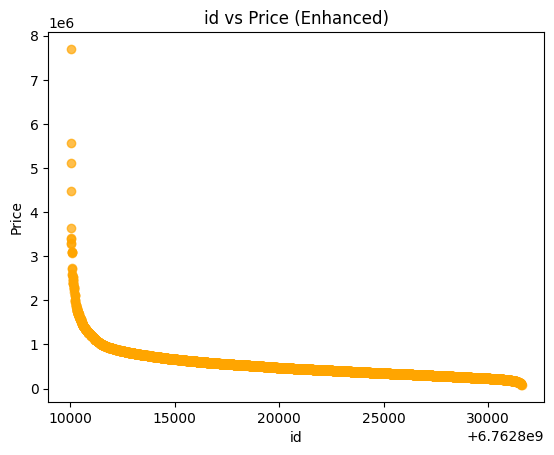

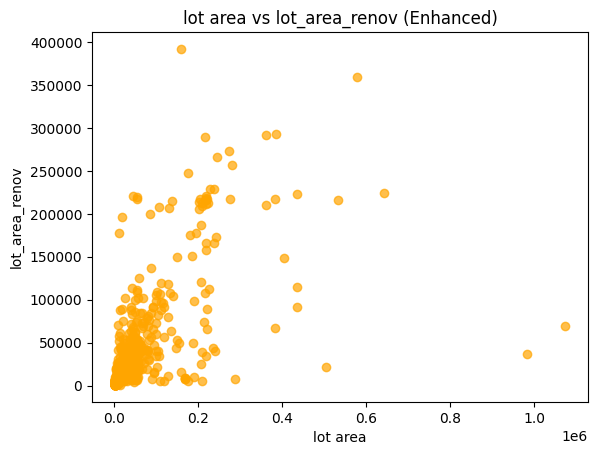

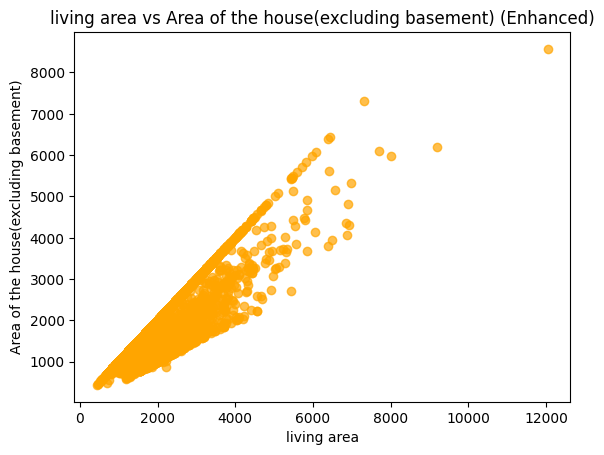

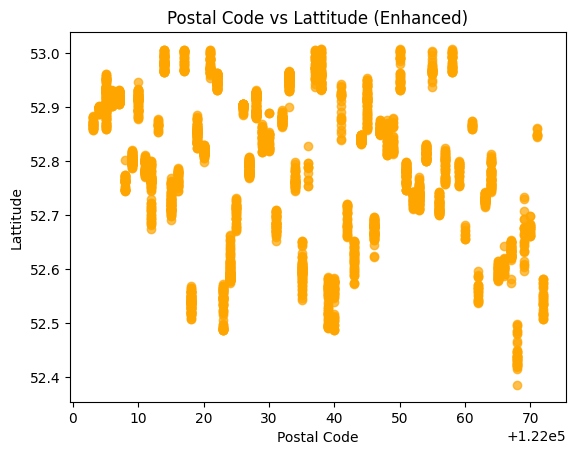

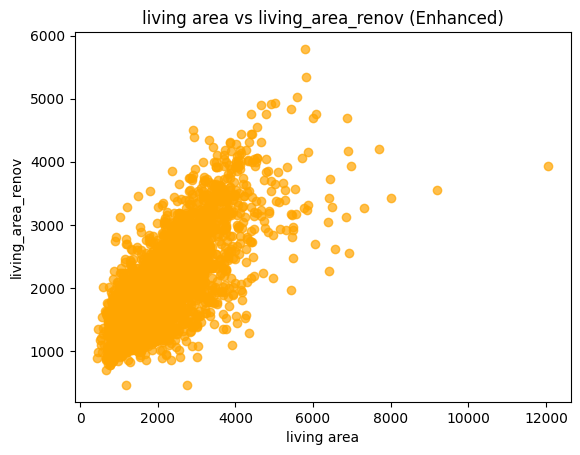

Enhanced Model Summary Metrics:
 - Enhanced Charts: 5
 - Avg Enhanced p-value: 0.0000
 - Avg Enhanced Mutual Information: 1.0360



{'Dataset': 'House Price India',
 'Enhanced_Charts': 5,
 'Baseline_Charts': 5,
 'Overlap_Percent': 60.0,
 'Avg_Enhanced_p-value': 0.0,
 'Avg_Baseline_p-value': 0.0,
 'Avg_Enhanced_MutualInfo': 1.036,
 'Avg_Baseline_MutualInfo': 0.888,
 'Readability_Enhanced': None,
 'Readability_Baseline': None}

In [3]:
run_visualization_pipeline("datasets/House Price India.csv", mode="normal")

In [4]:
run_visualization_pipeline(["./datasets/CC GENERAL.csv", "./datasets/medical_insurance.csv","./datasets/House Price India.csv", "./datasets/weatherAUS.csv" ], mode="compare", output_csv="comparison_results.csv", save_plots=True)

[INFO] CC GENERAL: Downsampled to 4000 rows.
=== Saving visualizations for CC GENERAL in COMPARE mode to 'compare_output' ===
Comparison Summary Metrics:
 - Baseline Charts: 5
 - Enhanced Charts: 5
 - Overlap: 2 overlapping charts (40.0%)
 - Avg Enhanced p-value: 0.0000, Baseline p-value: 0.0000
 - Avg Enhanced Mutual Info: 0.7251, Baseline Mutual Info: 0.5913

=== Saving visualizations for medical_insurance in COMPARE mode to 'compare_output' ===
Comparison Summary Metrics:
 - Baseline Charts: 13
 - Enhanced Charts: 13
 - Overlap: 12 overlapping charts (92.3%)
 - Avg Enhanced p-value: 0.0609, Baseline p-value: 0.0547
 - Avg Enhanced Mutual Info: 0.1261, Baseline Mutual Info: 0.1259

[INFO] House Price India: Downsampled to 4000 rows.
=== Saving visualizations for House Price India in COMPARE mode to 'compare_output' ===
Comparison Summary Metrics:
 - Baseline Charts: 5
 - Enhanced Charts: 5
 - Overlap: 3 overlapping charts (60.0%)
 - Avg Enhanced p-value: 0.0000, Baseline p-value: 0.0

,Dataset,Enhanced_Charts,Baseline_Charts,Overlap_Percent,Avg_Enhanced_p-value,Avg_Baseline_p-value,Avg_Enhanced_MutualInfo,Avg_Baseline_MutualInfo,Readability_Enhanced,Readability_Baseline
0,CC GENERAL,5,5,40.00,0.0000,0.0000,0.7251,0.5913,None,None
1,medical_insurance,13,13,92.31,0.0609,0.0547,0.1261,0.1259,None,None
2,House Price India,5,5,60.00,0.0000,0.0000,1.0360,0.8880,None,None
3,weatherAUS,15,15,66.67,0.0679,0.0000,1.1295,0.5604,None,None
